In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

# Motor Imagery

In [2]:
modules = ("Numpy",
           "Matplotlib",
           "MNE",
           "Sklearn",
           "OpenBCI",
           "ipywidgets",
#            "no-instaled-module",
          )

for module in modules:
    try:
        __import__(module.lower())
    except:
        print(f"'{module}' no está instalado!")
        print(f"pip install {module.lower()}")
        print("-"*70)

C:\ProgramData\Anaconda3\lib\site-packages\numba\decorators.py:146: RuntimeWarning: Caching is not available when the 'parallel' target is in use. Caching is now being disabled to allow execution to continue.
  warnings.warn(msg, RuntimeWarning)


In [3]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import json
import mne
from matplotlib.animation import FuncAnimation
from ipywidgets import interact
from openbci.preprocess import eeg_filters
#pip install --user --upgrade scipy
from mne.decoding import CSP
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC

## Previsualización de los datos de entrada

In [4]:
filename = "2019-07-19 17_41_51.820255"

Los datos del `EEG` están organizados en formato `CSV` de forma que cada columna representa un canal, la última columna contiene siempre los marcadores.

Input data size: (84318, 17)


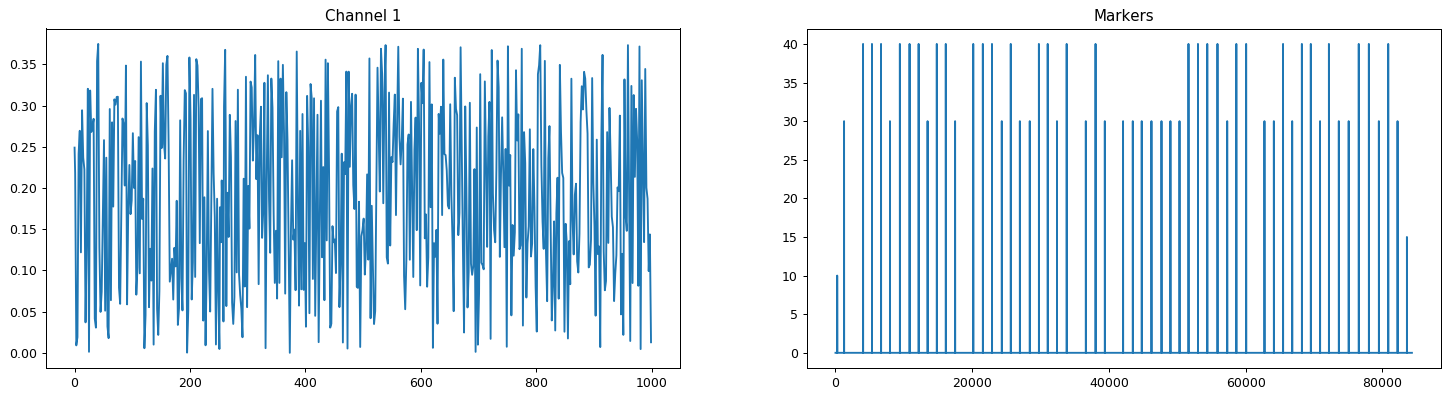

In [5]:
data = np.loadtxt(f"data/{filename}.csv", delimiter=',')
print(f"Input data size: {data.shape}")

plt.figure(figsize=(20, 5), dpi=90)  # ajusta el tamaño del gráfico

# Previsualizamos una columna
plt.subplot(121)
col1 = data[:,0]  # selecciona la primera columna
plt.plot(col1[:1000])  # grafica los primeos 1000 valores de esa columna
plt.title("Channel 1")

# Previsualizamos todos los marcadores
plt.subplot(122)
markers = data[:,-1]  # selecciona la última columna, usar data[:,-1] es equivalente a usar data[:,16]
plt.plot(markers)
plt.title("Markers")

plt.show()

Además del archivo que contiene el `EEG` hay un archivo extra que contiene los descriptores de la prueba, están en formato `JSON`.

In [6]:
descriptor = json.load(open(f"data/{filename}.json", 'r'))
descriptor

{'datetime': '2019-07-19 17:41:51.820255',
 'sample_rate': '249.6 Hz',
 'channels': 'Fp1, Fp2, F7, Fz, F8, C3, Cz, C4, T5, P3, Pz, P4, T6, O1, Oz, O2',
 'channels_system': '10-20',
 'start_marker': 10,
 'stop_marker': 15,
 'right_marker': 30,
 'left_marker': 40,
 'stimulus_end_marker': 5}

Con esta información se puede obtener una mejor previsualización de los datos

Sample rate: 249.6
Channels: ['FP1', 'FP2', 'F7', 'FZ', 'F8', 'C3', 'CZ', 'C4', 'T5', 'P3', 'PZ', 'P4', 'T6', 'O1', 'OZ', 'O2']
----------------------------------------------------------------------
Start marker position: [253]
Right marker positions: [ 1257  7966 13471 17497 24323 26967 28416 32396 36615 39394 42066 43486
 44793 46216 47685 48992 50319 57297 62745 64120 66802 70878 73622 75066
 79479 82213]
----------------------------------------------------------------------


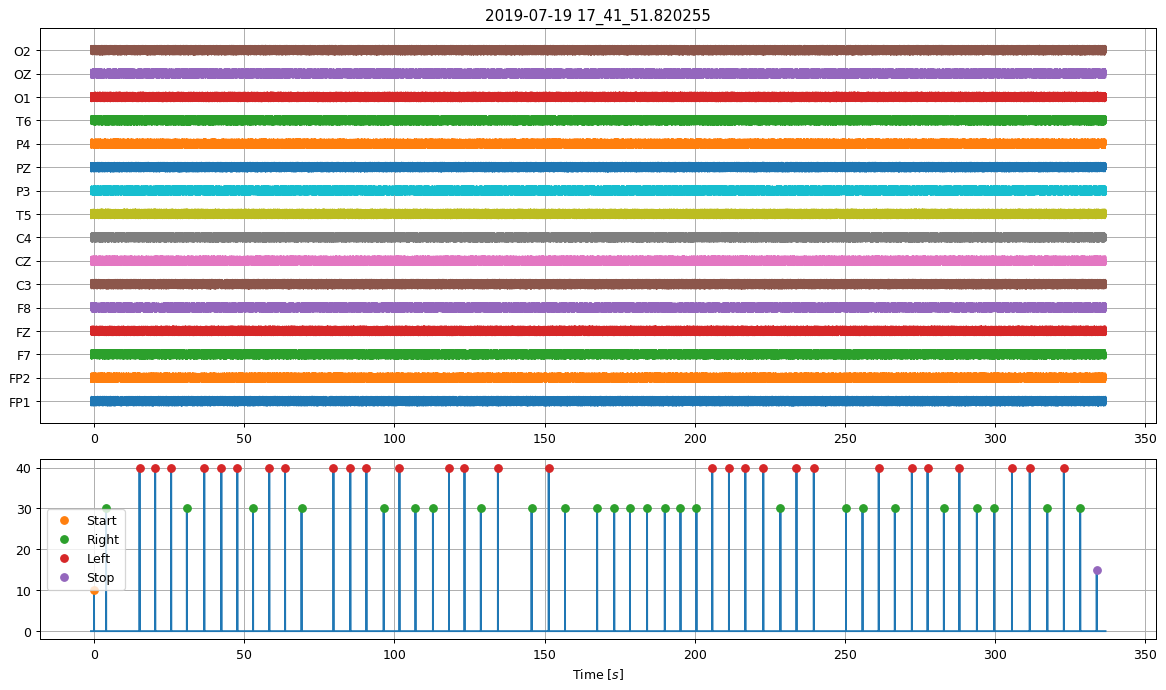

In [7]:
# Desde el descriptor se leen y transforman los valores necesarios
sample_rate = float(descriptor['sample_rate'].replace(' Hz', ''))  # convierte el string "247.8 Hz" en el flotante 247.8
start_marker = descriptor['start_marker']
stop_marker = descriptor['stop_marker']
left_marker = descriptor['left_marker']
right_marker = descriptor['right_marker']
channels_names = descriptor['channels'].split(',')  # convierte la cadena "Fp1, Fp2, F3..." en una lista de cadenas ["Fp1", "Fp2", "F3"...]
channels_names = [ch.upper().strip() for ch in channels_names]

print(f"Sample rate: {sample_rate}")
print(f"Channels: {channels_names}")
print("-"*70)

# Obtener las posiciones en donde se encuentra cada marcador
start = (np.where(data[:, -1] == start_marker)[0])
stop = (np.where(data[:, -1] == stop_marker)[0])
right = (np.where(data[:, -1] == right_marker)[0])
left = (np.where(data[:, -1] == left_marker)[0])

print(f"Start marker position: {start}")
print(f"Right marker positions: {right}")
print("-"*70)

#  Como se conoce la frecuencia de muestreo es posible recuperar el vector del tiempo
time = np.linspace(0, data.shape[0] / sample_rate, data.shape[0]) - start / sample_rate

fig = plt.figure(figsize=(16, 9), dpi=90)
gridsize = (3, 1)  # La proporción de los graficos que se van a visualizar

# Primer grafico con los canales de EEG
ax1 = plt.subplot2grid(gridsize, (0, 0), rowspan=2)
plt.title(filename)

# Se reemplazan los valores numéricos del eje Y por los nombres de los canales
ax1.set_yticks(range(0, len(channels_names)))
ax1.set_yticklabels(channels_names)

# Como los datos están en vertical (columnas) se reorientan con la transpuesta para poder visualizar los canales
for i, channel in enumerate(data[:,:-1].T):  # se ignora la última columna
    # Para que no queden los canales sobrepuestos, antes de graficar se centra y se le suma un entero para desplazarlo ligeramente hacia arriba.
    plt.plot(time, channel - channel.mean() + i)

# [plt.plot(t, d[0] - np.mean(d[1]) + d[1]) for d in enumerate(data[:, :-1].T)]

plt.grid(True)  #Activa la grilla

# Segundo grafico con los marcadores
ax2 = plt.subplot2grid(gridsize, (2, 0))
plt.plot(time, data[:, -1])  # solo se usa la última columna 
plt.grid(True)

# Se añaden marcadores de colores con su leyenda
plt.plot(time[start], data[:, -1][start], 'o', label='Start')
plt.plot(time[right], data[:, -1][right], 'o', label='Right')
plt.plot(time[left], data[:, -1][left], 'o', label='Left')
plt.plot(time[stop], data[:, -1][stop], 'o', label='Stop')
plt.legend()

plt.xlabel('Time [$s$]')
plt.show()

## Topoplot con MNE
Módulo Python de código abierto para explorar, visualizar y analizar datos neurofisiológicos humanos: MEG, EEG, sEEG, ECoG...

In [8]:
# Se crea un objeto con la montaje de los electrodos usados

montage = mne.channels.read_montage("standard_1020", channels_names)
info = mne.create_info(montage.ch_names, sfreq=sample_rate, ch_types="eeg", montage=montage)
info

C:\ProgramData\Anaconda3\lib\site-packages\mne\utils\docs.py:824: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\mne\utils\docs.py:807: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-8-0e033d609ead>:4: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_dig_polhem

<Info | 17 non-empty fields
    bads : list | 0 items
    ch_names : list | FP1, FP2, F7, FZ, F8, C3, CZ, C4, P3, ...
    chs : list | 16 items (EEG: 16)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    dig : Digitization | 19 items (3 Cardinal, 16 EEG)
    events : list | 0 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 124.8 Hz
    meas_date : NoneType | unspecified
    nchan : int | 16
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 249.6 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    device_info : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    helium_info : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType

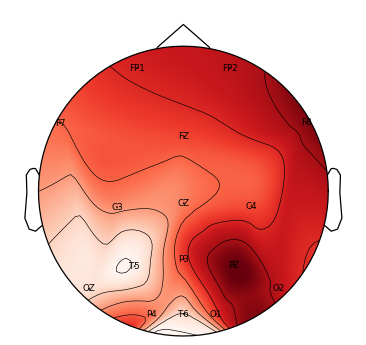

In [9]:
# Probamos que la configuración del montaje haya quedado correcta graficando un topoplot de ejemplo

values = data[:,:-1][0]  # el primer corte para los primeros 15 canales

plt.figure(figsize=(5, 5), dpi=90)
mne.viz.plot_topomap(values, info, names=channels_names, show_names=True)
plt.show()

## Filtrado y particionado de los datos

El objetivo de esta sección es tomar secciones de todos los canales de `EEG` de modo que estén sincronizados con los marcadores, es decir, se seleccionan los primeros `N` valores después de la aparición de un marcador, cada una de estas secciones se llama evento.

In [10]:
# Como hay que hacer un par de veces se define una función, que va a recibir los canales de EEG, el nombre del marcador y la cantidad de datos a seleccionar
def get_markers(data, marker_name, width):
    
    eeg_data = data[:,:-1]
    markers = data[:,-1]
    
    # esta función también se encarga de filtrar los datos y de convertirlos en potencia
    eeg_data = eeg_filters.band330(eeg_data.T).T
    eeg_data = eeg_data**2
    
    # además los datos se centralizan
    eeg_data = eeg_data - eeg_data.mean(axis=0)
    
    marker = descriptor[marker_name]
    index = np.argwhere(markers == marker).reshape(-1)
    
    print(f"Index for {marker_name}: {index}")
    return [eeg_data[start:start+width].copy() for start in index]

In [11]:
# La funcion definida requiere la cantidad de datos a seleccionar, se puede obtener este valor a partir de valor en tiempo
width = int(sample_rate*3)  # los primeros 3 segundos 

rights = get_markers(data, 'right_marker', width)
lefts = get_markers(data, 'left_marker', width)

print('-'*70)
print(f"{len(rights)} right markers")
print(f"{len(lefts)} left markers")

Index for right_marker: [ 1257  7966 13471 17497 24323 26967 28416 32396 36615 39394 42066 43486
 44793 46216 47685 48992 50319 57297 62745 64120 66802 70878 73622 75066
 79479 82213]
Index for left_marker: [ 4035  5336  6664  9416 10835 12162 14818 16132 20151 21553 22891 25637
 29752 31042 33817 38040 51634 53018 54383 55875 58633 60069 65466 68218
 69525 72173 76539 78016 80850]
----------------------------------------------------------------------
26 right markers
29 left markers


# Topoplots históricos para cada evento

In [12]:
def historical(data, N, name=""):
    
    # La primera fila son los `N` históricos para cada evento
    fig, axes = plt.subplots(nrows=1, ncols=N, figsize=(30, 8), dpi=90)
    for i, d in enumerate(np.linspace(0, len(data)-1, N)):
        values = data.copy()[int(d)]
        mne.viz.plot_topomap(values, info, axes=axes[i], show=False)
    
    # El título del grafico es su posisción el tiempo correspondiente
    for i, t in enumerate(np.linspace(0, 4, N)):
        axes[i].set_title(f"{t:.02}s")
    
    if name:
        axes[0].set_ylabel(name)
    
#     # Grafica la media de todo el evento
#     plt.figure(figsize=(30, 6), dpi=90)
#     ax = plt.subplot(111)
#     values = data.copy().mean(axis=0)
#     mne.viz.plot_topomap(values, info, axes=ax, show=False)
#     plt.title("Mean")

    plt.show() 

Esta parte del código usa `ipywidgets`, se puede consultar la guia de instalación en: https://ipywidgets.readthedocs.io/en/latest/user_install.html  
Sin embargo no son necesario.

In [13]:
# @interact(event=(0, len(rights), 1)) # slider en lugar de combobox
@interact(event=range(len(rights)))
def show_frame(event=0):
    historical(rights[event], N=12, name="Right")

interactive(children=(Dropdown(description='event', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

In [14]:
# @interact(event=(0, len(lefts), 1))
@interact(event=range(len(lefts)))
def show_frame(event=0):
    historical(lefts[event], N=12, name="Left")

interactive(children=(Dropdown(description='event', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

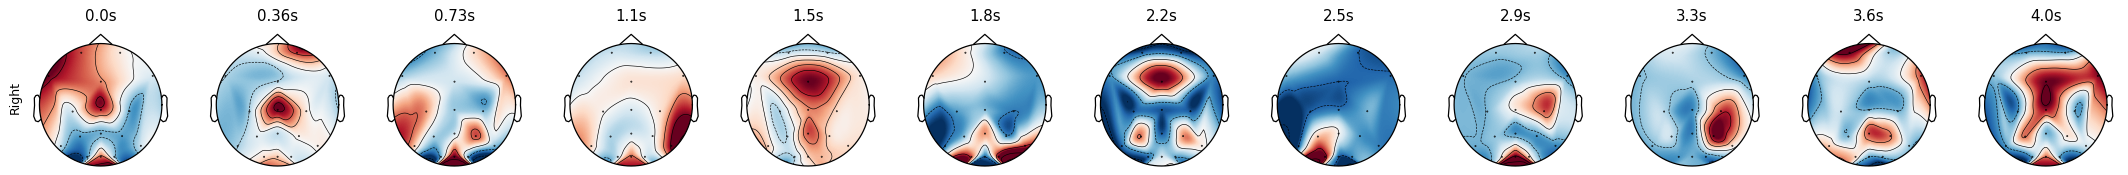

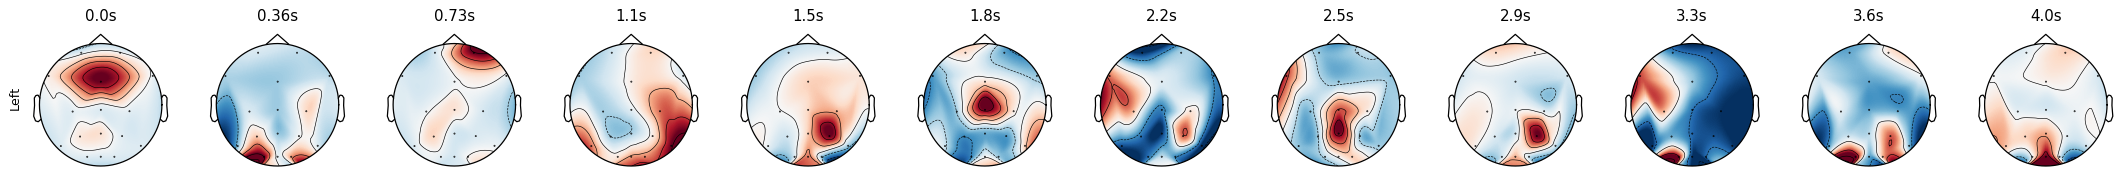

In [15]:
# En caso de no tener configurados los ipywidgets

# para el evento 0 del conjunto de rights
historical(rights[0], N=12, name="Right")

# para el evento 5 del conjunto de lefts
historical(lefts[5], N=12, name="Left")

# Análisis pre-exploratorio

In [16]:
# Se unen todos los eventos y se crea un vector de salida
Xraw = np.concatenate((rights, lefts))
Xraw = np.array([x.T for x in Xraw])

y = np.array([1]*len(rights) + [-1]*len(lefts))  # 1:derecha y -1:izquierda

print(f"Input: {Xraw.shape}")
print(f"Output: {y.shape}")

Input: (55, 16, 748)
Output: (55,)


Computing data rank from raw with rank=None
    Using tolerance 0.0028 (2.2e-16 eps * 16 dim * 7.9e+11  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.
Computing data rank from raw with rank=None
    Using tolerance 0.0027 (2.2e-16 eps * 16 dim * 7.5e+11  max singular value)
    Estimated rank (mag): 16
    MAG: rank 16 computed from 16 data channels with 0 projectors
Reducing data rank from 16 -> 16
Estimating covariance using EMPIRICAL
Done.


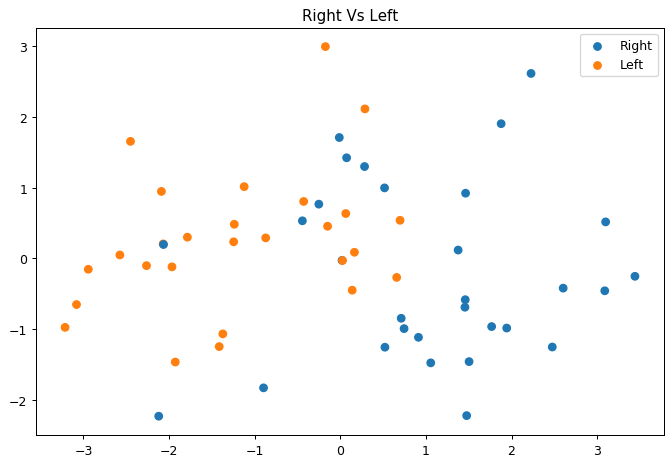

In [17]:
csp_epochs = CSP(n_components=8, reg='empirical', log=True, norm_trace=False, transform_into='average_power')
csp_epochs.fit(Xraw, y)

scaler = StandardScaler()
Xcsp = csp_epochs.transform(Xraw)
Xdataz = scaler.fit_transform(Xcsp)
pca = PCA(n_components=2)
Z = pca.fit_transform(Xdataz)

fig = plt.figure(figsize=(9, 6), dpi=90)
plt.title("Right Vs Left")

yc = ["C0" if (i == -1) else 'C1' for i in y]
plt.scatter(*Z.T, c=yc)

plt.scatter(*Z[0], c="C0", label='Right')
plt.scatter(*Z[-1], c="C1", label='Left')
plt.legend()

plt.show()
fig.savefig("versus.png")